<a href="https://colab.research.google.com/github/HannahBabe/audio_spoof_detection/blob/main/FinalProjectSubmission_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download Data Set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/sasv-challenge/SASVC2022_Baseline.git

In [ ]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:
!python ./aasist/download_dataset.py

python3: can't open file './aasist/download_dataset.py': [Errno 2] No such file or directory


In [ ]:
!pip install tensorflow-io

     |████████████████████████████████| 23.4 MB 43.9 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import os

#Analyzing Audio File

In [ ]:
import tensorflow as tf
import tensorflow_io as tfio

audio = tfio.audio.AudioIOTensor('LA_T_8209686.flac')

print(audio)

<AudioIOTensor: shape=[53851     1], dtype=<dtype: 'int16'>, rate=16000>


In [ ]:
audio_slice = audio[100:]

# remove last dimension
audio_tensor = tf.squeeze(audio_slice, axis=[-1])

print(audio_tensor)

tf.Tensor([-45 -48 -48 ...  61  65  71], shape=(53751,), dtype=int16)


In [ ]:
from IPython.display import Audio

Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

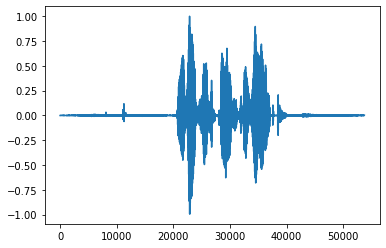

In [ ]:
import matplotlib.pyplot as plt
tensor = tf.cast(audio_tensor, tf.float32) / 32768.0

plt.figure()
plt.plot(tensor.numpy())

tf.Tensor([11282 38771], shape=(2,), dtype=int64)
tf.Tensor(11282, shape=(), dtype=int64) tf.Tensor(38771, shape=(), dtype=int64)


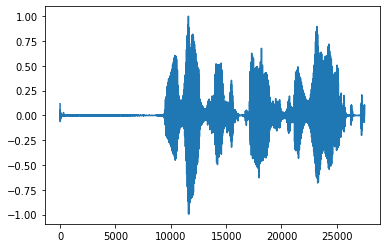

In [ ]:
position = tfio.audio.trim(tensor, axis=0, epsilon=0.1)
print(position)

start = position[0]
stop = position[1]
print(start, stop)

processed = tensor[start:stop]

plt.figure()
plt.plot(processed.numpy())

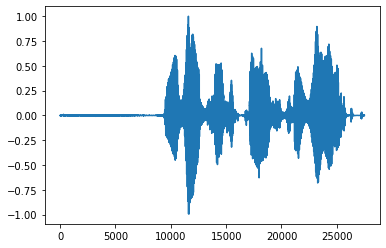

In [ ]:
fade = tfio.audio.fade(
    processed, fade_in=1000, fade_out=2000, mode="logarithmic")

plt.figure()
plt.plot(fade.numpy())

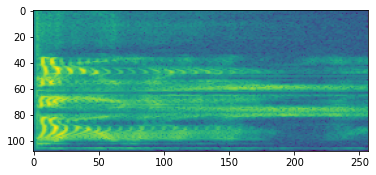

In [ ]:
# Convert to spectrogram
spectrogram = tfio.audio.spectrogram(
    fade, nfft=512, window=512, stride=256)

plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())

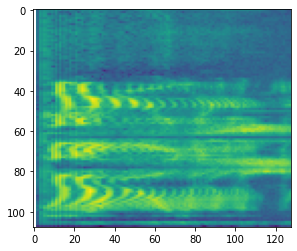

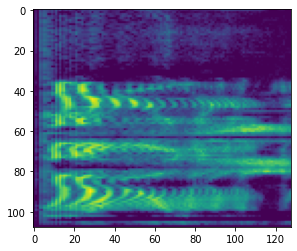

In [ ]:
# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)


plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())

#Pre-Process Training Data

Goal: Convert audio files into spectograms, define training (audio file) and validation (class ID) sets

In [ ]:
%cd /content/drive/MyDrive/Github/SASVC2022_Baseline/LA/

/content/drive/MyDrive/Github/SASVC2022_Baseline/LA


In [ ]:
# ----------------------------
# Prepare training data from Metadata file
# ----------------------------
import pandas as pd
import numpy as np
from pathlib import Path

download_path = Path.cwd()

# Read metadata file and convert to csv
read_file_train = pd.read_csv(download_path/'ASVspoof2019_LA_cm_protocols'/'ASVspoof2019.LA.cm.train.trn.txt', delim_whitespace=True, header=None)
read_file_train.to_csv (download_path/'ASVspoof2019_LA_cm_protocols'/'ASVspoof2019.LA.cm.train.trn.csv', index=None)
metadata_file_train = download_path/'ASVspoof2019_LA_cm_protocols'/'ASVspoof2019.LA.cm.train.trn.csv'
df_train = pd.read_csv(metadata_file_train)

# Construct file path by concatenating file name and .flac
df_train['relative_path'] = df_train['1'].astype(str) + '.flac'

# Take relevant columns
df_train = df_train[['relative_path', '4']]
df_train.rename(columns={"4": "key"}, inplace=True)

df_train.index.name = 'idx'

df_train['key_binary'] = np.where(df_train['key']=='bonafide', 1, 0)
df_train.head()


,relative_path,key,key_binary
idx,,,
0,LA_T_1138215.flac,bonafide,1
1,LA_T_1271820.flac,bonafide,1
2,LA_T_1272637.flac,bonafide,1
3,LA_T_1276960.flac,bonafide,1
4,LA_T_1341447.flac,bonafide,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


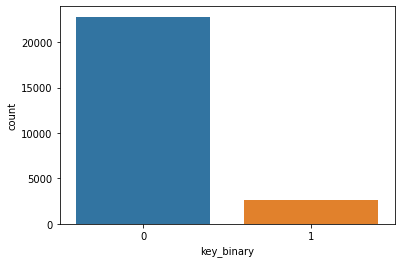

In [ ]:
#plot number of elements in each class in df_train
import seaborn as sns
sns.countplot(df_train['key_binary'])

In [ ]:
import librosa
import csv
lengths = []
with open(download_path/'ASVspoof2019_LA_cm_protocols'/'ASVspoof2019.LA.cm.train.trn.txt', 'r') as _filehandler:
    csv_file_reader = csv.DictReader(_filehandler, delimiter=' ')
    for row in csv_file_reader:
      dur = librosa.get_duration(filename=row['LA_T_1138215']+'.flac')
      lengths.append(dur)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


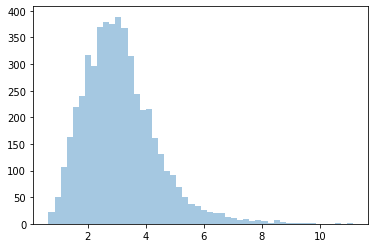

In [ ]:
#lengths of each audio file
import seaborn as sns
sns.distplot(lengths, kde=False)

In [ ]:
# ----------------------------
# Prepare validation/dev data from Metadata file --- not completed. Need to split the column. 
# ----------------------------

import pandas as pd
from pathlib import Path

download_path = Path.cwd()

# Read metadata file and convert to csv --- Ask about this in class
read_file_dev = pd.read_csv(download_path/'ASVspoof2019_LA_cm_protocols'/'ASVspoof2019.LA.cm.dev.trl.txt',sep=',', skiprows=5, header=None)
read_file_dev.to_csv (download_path/'ASVspoof2019_LA_cm_protocols'/'ASVspoof2019.LA.cm.dev.trl.csv', index=None)
metadata_file_dev = download_path/'ASVspoof2019_LA_cm_protocols'/'ASVspoof2019.LA.cm.dev.trl.csv'
df_dev = pd.read_csv(metadata_file_dev)
df_dev['0'] = df_dev['0'].astype(str)
df_dev[[1,'file_name',3,4,'key']]=df_dev['0'].str.split(",", expand=True)

# Construct file path by concatenating file name and .flac
df_dev['relative_path'] = 'ASVspoof2019_LA_dev/flac/' + df_dev['file_name'].astype(str) + '.flac'

df_dev = df_dev[['relative_path','key']]

df_dev.index.name = 'idx'

df_dev['key_binary'] = np.where(df_dev['key']=='bonafide', 1, 0)
df_dev.head()

,relative_path,key,key_binary
idx,,,
0,ASVspoof2019_LA_dev/flac/LA_D_1047731.flac,bonafide,1
1,ASVspoof2019_LA_dev/flac/LA_D_1105538.flac,bonafide,1
2,ASVspoof2019_LA_dev/flac/LA_D_1125976.flac,bonafide,1
3,ASVspoof2019_LA_dev/flac/LA_D_1293230.flac,bonafide,1
4,ASVspoof2019_LA_dev/flac/LA_D_1340209.flac,bonafide,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


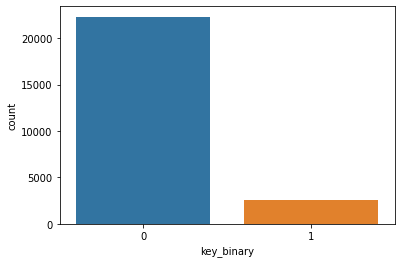

In [ ]:
#plot number of elements in each class in df_dev
import seaborn as sns
sns.countplot(df_dev['key_binary'])

In [ ]:
# ----------------------------
# Prepare evaluation/eval data from Metadata file
# ----------------------------
import pandas as pd
import numpy as np
from pathlib import Path

download_path = Path.cwd()

# Read metadata file and convert to csv
read_file_eval = pd.read_csv(download_path/'ASVspoof2019_LA_cm_protocols'/'ASVspoof2019.LA.cm.eval.trl.txt', delim_whitespace=True, header=None)
read_file_eval.to_csv (download_path/'ASVspoof2019_LA_cm_protocols'/'ASVspoof2019.LA.cm.eval.trn.csv', index=None)
metadata_file_eval = download_path/'ASVspoof2019_LA_cm_protocols'/'ASVspoof2019.LA.cm.eval.trn.csv'
df_eval = pd.read_csv(metadata_file_eval)

# Construct file path by concatenating file name and .flac
df_eval['relative_path'] = df_eval['1'].astype(str) + '.flac'

# Take relevant columns
df_eval = df_eval[['relative_path', '4']]
df_eval.rename(columns={"4": "key"}, inplace=True)

df_eval.index.name = 'idx'

df_eval['key_binary'] = np.where(df_eval['key']=='bonafide', 1, 0)
df_eval.head()

,relative_path,key,key_binary
idx,,,
0,LA_E_2834763.flac,spoof,0
1,LA_E_8877452.flac,spoof,0
2,LA_E_6828287.flac,spoof,0
3,LA_E_6977360.flac,spoof,0
4,LA_E_5932896.flac,spoof,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


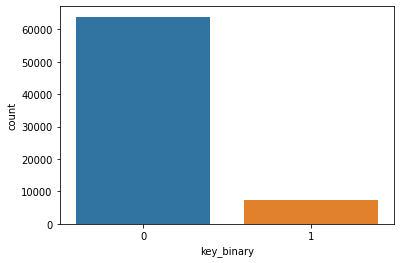

In [ ]:
#plot number of elements in each class in df_eval
import seaborn as sns
sns.countplot(df_eval['key_binary'])

In [ ]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import tensorflow_io as tfio

class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    audio = tfio.audio.AudioIOTensor(audio_file)
    audio_slice = audio[100:]
    audio_squeezed = tf.squeeze(audio_slice, axis=[-1])
    return audio_squeezed

  # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' defined to be 3000 in milliseconds
  # ----------------------------
  def pad_trunc(aud, max_ms):
      sig_len = aud.shape[0]
      max_len = 16 * max_ms #sample rate of 16000/1000

      if (sig_len > max_len):
        # Truncate the signal to the given length
        aud = aud[0:max_len]

      elif (sig_len < max_len):
        # Length of padding to add at the beginning and end of the signal
        pad_begin_len = random.randint(0, max_len - sig_len)
        pad_end_len = max_len - sig_len - pad_begin_len

        # Pad with 0s
        pad_begin = tf.constant([0]*pad_begin_len, dtype='int16')
        pad_end = tf.constant([0]*pad_end_len, dtype='int16')

        aud = tf.concat([pad_begin, aud, pad_end], 0)
  
      return aud

  # ----------------------------
  # Generate a Spectrogram
  # ----------------------------
  @staticmethod
  def spectro_gram(aud):
    tensor = tf.cast(aud, tf.float32) / 32768.0
    # Convert to spectrogram
    spectrogram = tfio.audio.spectrogram(tensor, nfft=512, window=512, stride=256)
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)
    dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
    return (tf.reshape((dbscale_mel_spectrogram),[188, 128,1]))

In [ ]:
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    #'Generates data for Keras'
    def __init__(self, df, batch_size=32, dim=(188, 128), n_channels=1,
                 n_classes=2, shuffle=False, duration=3000, data_path='/content/drive/MyDrive/Github/SASVC2022_Baseline/LA/'):
        #'Initialization'
        self.df = df
        self.dim = dim
        self.batch_size = batch_size
        self.list_indexes = df.index
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.duration = duration
        self.data_path = data_path
        self.on_epoch_end()

    def __len__(self):
        #'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_indexes) / self.batch_size))

    def getkey(self,idx):
      # Get the key (spoof or bonafide)
      key = self.df.loc[self.df.index[idx], 'key_binary']
      return key

    def __getitem__(self, index):
        #'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
       # list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        #'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_indexes))
        #if self.shuffle == True:
         #   np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        #'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, idx in enumerate(indexes):
            # Store sample
            X[i,] = x_train_spectrogram[idx]

            # Store class
            y[i] = self.getkey(idx)

        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

Create h5py file -- Don't need to run this again. 

In [ ]:
%cd /content/drive/MyDrive/Github/SASVC2022_Baseline/LA/ASVspoof2019_LA_train/flac/

/content/drive/MyDrive/Github/SASVC2022_Baseline/LA/ASVspoof2019_LA_train/flac


In [ ]:
# Dont run - eval
%cd /content/drive/MyDrive/Github/SASVC2022_Baseline/LA/ASVspoof2019_LA_eval/flac/

x_eval=[]
count=0
for filename in df_eval['relative_path']:
  if (count<5000):
    try:
      audio = AudioUtil.open(filename)
      dur_aud = AudioUtil.pad_trunc(audio, 3000)
      sgram = AudioUtil.spectro_gram(dur_aud)
      x_eval.append((filename,sgram))
      count+=1
      if (count%500==0):
        print(count)
    except:
      pass
  else: 
    break

/content/drive/MyDrive/Github/SASVC2022_Baseline/LA/ASVspoof2019_LA_eval/flac
500
1000
1500
2000
2500
3000
3500
4000
4500
5000


In [ ]:
df_eval.index[df_eval['relative_path']=='LA_E_9315313.flac'].tolist()

[9609]

In [ ]:
# Dont run - eval - append more bonafide files
%cd /content/drive/MyDrive/Github/SASVC2022_Baseline/LA/ASVspoof2019_LA_eval/flac/

x_eval_bonafide=[]
count=0
for idx,row in df_eval[9610:].iterrows():
  if (row['key_binary']==1):
    if (count<4500):
      try:
        audio = AudioUtil.open(row['relative_path'])
        dur_aud = AudioUtil.pad_trunc(audio, 3000)
        sgram = AudioUtil.spectro_gram(dur_aud)
        x_eval.append((filename,sgram))
        count+=1
        if (count%500==0):
          print(count)
      except:
        pass
    else: 
      break

/content/drive/MyDrive/Github/SASVC2022_Baseline/LA/ASVspoof2019_LA_eval/flac
500
1000
1500
2000
2500
3000


In [ ]:
x_eval.append(x_eval_bonafide)

In [ ]:
#converts all spectrograms to dtype 'float32'
for item in x_eval:
  if (item[1].dtype!='float32'):
    item[1].astype(np.float32)

IndexError: ignored

In [ ]:
x_eval_spec = []

In [ ]:

#appeds all spectrograms from x_eval to x_eval_spec (just selects second item from tuple)
for item in x_eval:
  try:
    x_eval_spec.append(item[1])
  except:
    pass

In [ ]:
#appends all rows from df_eval that have a matching filename in x_eval to df_x_eval
df_x_eval = []
for item in x_eval:
  try:
    df_x_eval.append(df_eval.loc[df_eval['relative_path'] == item[0]])
  except:
    pass

In [ ]:
#gets key_binary from df_x_eval for all relevant files and appends to df_y_eval
df_y_eval = []
for item in df_x_eval:
  df_y_eval.append(item['key_binary'].astype(str).astype(int))
df_y_eval = list(df_y_eval)

In [ ]:
# Dont Run - eval
import h5py

%cd /content/drive/MyDrive/Github/SASVC2022_Baseline/LA/ASVspoof2019_LA_eval/
hf_eval = h5py.File('eval_spectrograms4.h5', 'w')
hf_eval.create_dataset('dataset_eval', data=x_eval_spec)
hf_eval.close()

/content/drive/MyDrive/Github/SASVC2022_Baseline/LA/ASVspoof2019_LA_eval


In [ ]:
with h5py.File('eval_spectrograms_keys.h5', 'w') as hf:
  hf.create_dataset('dataset_eval_keys', data = df_y_eval)
hf.close()

In [ ]:
# Dont run - train 
%cd /content/drive/MyDrive/Github/SASVC2022_Baseline/LA/ASVspoof2019_LA_train/flac/

x_train=[]
for filename in df_train['relative_path']:
  audio = AudioUtil.open(filename)
  dur_aud = AudioUtil.pad_trunc(audio, 3000)
  sgram = AudioUtil.spectro_gram(dur_aud)
  x_train.append(sgram)

/content/drive/MyDrive/Github/SASVC2022_Baseline/LA/ASVspoof2019_LA_train/flac


In [ ]:
# Dont Run - train
import h5py

%cd /content/drive/MyDrive/Github/SASVC2022_Baseline/LA/ASVspoof2019_LA_train/flac/
hf_train = h5py.File('train_spectrograms.h5', 'w')
hf_train.create_dataset('dataset_train', data=x_train)

In [ ]:
#Get train
import numpy as np
import h5py


%cd /content/drive/MyDrive/Github/SASVC2022_Baseline/LA/ASVspoof2019_LA_train/
hf_train = h5py.File('spectrograms.h5', 'r')
x_train_spectrogram = hf_train.get('dataset_train')
x_train_spectrogram = np.array(x_train_spectrogram)
hf_train.close()

/content/drive/MyDrive/Github/SASVC2022_Baseline/LA/ASVspoof2019_LA_train


In [ ]:
y_train = df_train["key_binary"]

In [ ]:
y_train[3456]

0

In [ ]:
import tensorflow as tf
import tensorflow_io as tfio
from IPython.display import Audio

audio = tfio.audio.AudioIOTensor(df_train['relative_path'][3456])
audio_slice = audio[100:]

# remove last dimension
audio_tensor = tf.squeeze(audio_slice, axis=[-1])

Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

In [ ]:
test_spec_3456 = x_train_spectrogram[3456]

In [ ]:
filename_3456 = df_train['relative_path'][3456]
audio = AudioUtil.open(filename_0)
dur_aud = AudioUtil.pad_trunc(audio, 3000)
sgram_0 = AudioUtil.spectro_gram(dur_aud)


In [ ]:
test_spec_3456==sgram_0

<tf.Tensor: shape=(188, 128, 1), dtype=bool, numpy=
array([[[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       ...,

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]]])>

In [ ]:
#get eval_spec
import h5py
import numpy as np
%cd /content/drive/MyDrive/Github/SASVC2022_Baseline/LA/ASVspoof2019_LA_eval/
hf_eval = h5py.File('eval_spectrograms4.h5','r')
x_eval_spectrogram = hf_eval.get('dataset_eval')
x_eval_spectrogram = np.array(x_eval_spectrogram)
hf_eval.close()

/content/drive/MyDrive/Github/SASVC2022_Baseline/LA/ASVspoof2019_LA_eval


In [ ]:
#get eval_keys
import h5py
import numpy as np
%cd /content/drive/MyDrive/Github/SASVC2022_Baseline/LA/ASVspoof2019_LA_eval/
hf = h5py.File('eval_spectrograms_keys.h5','r')
y_eval = hf.get('dataset_eval_keys')
y_eval = np.array(y_eval)
hf.close()

/content/drive/MyDrive/Github/SASVC2022_Baseline/LA/ASVspoof2019_LA_eval


In [ ]:
print(x_eval_spectrogram.size, y_eval.size)


196795392 8178


In [ ]:
key_0 = 0
key_1 = 0
for item in y_eval:
  if item[0]==0:
    key_0+=1
  else:
    key_1+=1

In [ ]:
print(key_0,key_1)

4471 3707


In [ ]:
data_path = '/content/drive/MyDrive/Github/SASVC2022_Baseline/LA/'
%cd /content/drive/MyDrive/Github/SASVC2022_Baseline/LA/ASVspoof2019_LA_train/flac/

# item shape = (num_channels, Mel freq_bands, time_steps) 
#batch shape = (batch_sz, num_channels, Mel freq_bands, time_steps)

params = {'dim': (188, 128),
          'batch_size': 64,
          'n_classes': 2,
          'n_channels': 1,
          'duration': 3000,
          'shuffle': True,
          'data_path' : data_path}

# Generators
training_generator = DataGenerator(df_train, **params)
#validation_generator = DataGenerator(df_dev, **params)

/content/drive/MyDrive/Github/SASVC2022_Baseline/LA/ASVspoof2019_LA_train/flac


# Build Model 

Input: A batch of images (batch_sz, num_channels, Mel freq_bands, time_steps)

Output: Class prediction


Model inspired by NeMO https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speech_classification/models.html#id2

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import layers

# filters, shape

model = Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(188, 128,1)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.3))

###final layer
model.add(layers.Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 188, 128, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 188, 128, 32)     128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 188, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 186, 126, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 186, 126, 64)     256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 186, 126, 64)      0

Model from https://www.section.io/engineering-education/machine-learning-for-audio-classification/

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

model=Sequential()
###first layer
model.add(Dense(100,input_shape=(188, 128,1)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Flatten())
model.add(Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 188, 128, 100)     200       
                                                                 
 activation (Activation)     (None, 188, 128, 100)     0         
                                                                 
 dropout (Dropout)           (None, 188, 128, 100)     0         
                                                                 
 dense_1 (Dense)             (None, 188, 128, 200)     20200     
                                                                 
 activation_1 (Activation)   (None, 188, 128, 200)     0         
                                                                 
 dropout_1 (Dropout)         (None, 188, 128, 200)     0         
                                                                 
 dense_2 (Dense)             (None, 188, 128, 100)    

Model Test

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import layers

# filters, shape

model = Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(188, 128,1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid')) 

In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 188, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 94, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 94, 64, 32)        0         
                                                                 
 flatten (Flatten)           (None, 192512)            0         
                                                                 
 dense (Dense)               (None, 1)                 192513    
                                                                 
Total params: 192,833
Trainable params: 192,833
Non-trainable params: 0
__________________________________________________

Model Option 2

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import layers

# filters, shape

model = Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(188, 128,1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid')) 

In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 188, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 94, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 94, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 62, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 365056)            0         
                                                                 
 dense (Dense)               (None, 64)                23363648  
                                                        

Model option 1:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import layers

# filters, shape

model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [ ]:
model.compile(loss="mse", optimizer="adam", metrics=['accuracy', tf.keras.metrics.Recall()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

#Train Model (todo)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=20, restore_best_weights=True, monitor='accuracy')

In [ ]:
class_weight = {0: 10.,
                1: 1.}

In [ ]:
model.fit( training_generator,
          batch_size=256,
          use_multiprocessing=True,
          epochs=1,
          callbacks=[es],
          class_weight=class_weight)

 38/396 [=>............................] - ETA: 3:53 - loss: 49.2050 - accuracy: 0.5000

Process Keras_worker_ForkPoolWorker-1:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
%cd /content/drive/MyDrive/Github/SASVC2022_Baseline/LA/
model.save('model1')

/content/drive/MyDrive/Github/SASVC2022_Baseline/LA
INFO:tensorflow:Assets written to: model1/assets


In [ ]:
%cd /content/drive/MyDrive/Github/SASVC2022_Baseline/LA/
reconstructed_model = keras.models.load_model("model1")

/content/drive/MyDrive/Github/SASVC2022_Baseline/LA


#Evaluate Model (todo)

In [ ]:
print(model.evaluate(training_generator))

 48/396 [==>...........................] - ETA: 45s - loss: 0.6932 - accuracy: 0.5000

KeyboardInterrupt: ignored

In [ ]:
print(model.evaluate(x_eval_spectrogram, y_eval))

256/256 [==============================] - 22s 84ms/step - loss: 0.6939 - accuracy: 0.4533
[0.693897008895874, 0.45328930020332336]


In [ ]:
for k in training_generator:
  print(k)
  break

(array([[[[-44.48979187],
         [-44.48979187],
         [-44.48979187],
         ...,
         [-44.48979187],
         [-44.48979187],
         [-44.48979187]],

        [[-44.48979187],
         [-44.48979187],
         [-44.48979187],
         ...,
         [-44.48979187],
         [-44.48979187],
         [-44.48979187]],

        [[-44.48979187],
         [-44.48979187],
         [-44.48979187],
         ...,
         [-44.48979187],
         [-44.48979187],
         [-44.48979187]],

        ...,

        [[-44.48979187],
         [-44.48979187],
         [-44.48979187],
         ...,
         [-44.48979187],
         [-44.48979187],
         [-44.48979187]],

        [[-44.48979187],
         [-44.48979187],
         [-44.48979187],
         ...,
         [-44.48979187],
         [-44.48979187],
         [-44.48979187]],

        [[-44.48979187],
         [-44.48979187],
         [-44.48979187],
         ...,
         [-44.48979187],
         [-44.48979187],
         [-44.48

In [ ]:
preds = model.predict(training_generator)

print(preds[:100])

[[0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]
 [0.5001363]

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

preds = model.predict(x_eval_spectrogram)

conf=confusion_matrix(y_eval, y_pred)
print(conf)

[[4471    0]
 [3707    0]]


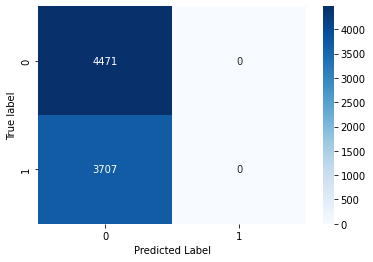

In [ ]:
ax = sns.heatmap(conf, annot=True, fmt='d', cmap='Blues') 
ax.set(xlabel='Predicted Label',
       ylabel='True label');

In [ ]:
from sklearn.metrics import confusion_matrix
conf=confusion_matrix(y_test, preds_label)
ax = sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
ax.set(xlabel = 'Predicted Label', 
       ylabel = 'True Label')